# Relevance backpropagation with deep taylor decomposition

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from lrp_layers import LRPLinear, LRPReLU
from torch.utils.data import DataLoader, Dataset
from utils import MNISTData
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import numpy as np

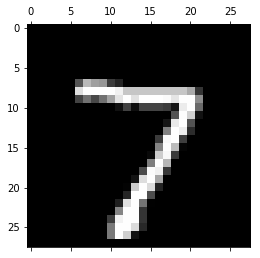

In [2]:
# Load data and display sample
X, y = MNISTData('data')
plt.gray()
plt.matshow(X[0].reshape((28, 28)))
plt.show()

In [3]:
# Build dataset
class MNISTDataset(Dataset):
    
    def __init__(self, path):
        self.X, self.y = MNISTData(path)
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx, :]).float(), torch.from_numpy(self.y[idx, :]).float()

In [4]:
# Build model
model = nn.Sequential(
            LRPLinear(784, 200), LRPReLU(),
            LRPLinear(200, 100), LRPReLU(),
            LRPLinear(100, 10))

In [5]:
# Train the model
MNISTDataloader = DataLoader(MNISTDataset('data'), batch_size=20, shuffle=True)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
n_epochs = 1

for epoch in range(n_epochs):
    running_loss = 0.
    for i, batch in enumerate(MNISTDataloader, 0):
        inputs, labels = batch
        labels = torch.max(labels, 1)[1]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i%100 == 99:
            print("Epoch %s, batch %s, loss: %.3f" % (epoch, i+1, running_loss))
            running_loss = 0.
print("Finished training!")

Epoch 0, batch 100, loss: 111.746
Epoch 0, batch 200, loss: 45.910
Epoch 0, batch 300, loss: 33.920
Epoch 0, batch 400, loss: 29.711
Epoch 0, batch 500, loss: 28.079
Finished training!


In [6]:
# Relevance backpropagation
random_index = np.random.randint(0, high=X.shape[0], size=(3))
sample = X[random_index, :]
sample = torch.from_numpy(sample).float()
label = y[random_index, :]
label = torch.from_numpy(label).float()
output = model(sample)
R = output * label
for i in range(len(model)-1):
    R = model[-i-1].backward_relevance(R, rule="z+")
R = model[0].backward_relevance(R, rule="zbeta")

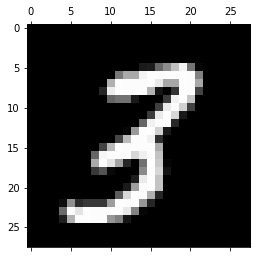

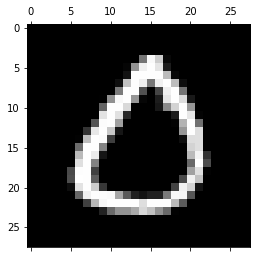

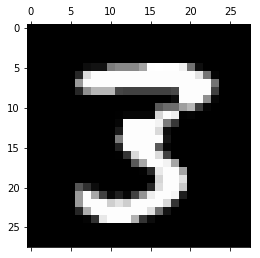

In [7]:
# Display the sample
for i in range(sample.shape[0]):
    plt.gray()
    plt.matshow(sample[i, :].reshape((28, 28)))
    plt.show()

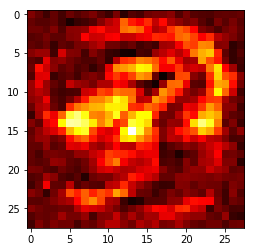

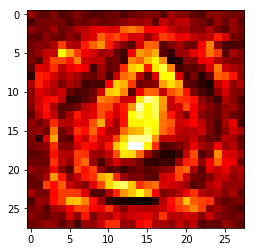

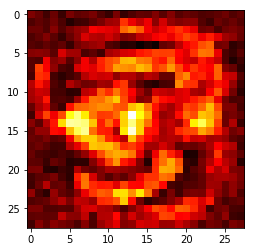

In [8]:
# Display the relevance heatmap
R = R.detach().data.numpy()
for i in range(R.shape[0]):
    R_i = R[i].reshape((28, 28))
    plt.imshow(R_i, cmap='hot', interpolation='nearest')
    plt.show()